# Libraries

In [1]:
from cdasws import CdasWs
import pandas as pd
import numpy as np
from spacepy import pycdf
import matplotlib as plt
from dtw import *
cdas = CdasWs()
plt.rcParams["figure.figsize"] = [20, 10]

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Step 1 - Loading Datasets: DSCOVER, WIND, WIND SWE

In [33]:
vars_wind = ['BF1','BGSM','BGSE']
time = ['2022-08-25T22:15:00.000Z', '2022-08-25T22:20:00.000Z']
#time = ['2022-09-10T22:58:59.000Z', '2022-09-17T22:59:59.000Z']
status_wind, data_wind = cdas.get_data('WI_H2_MFI', vars_wind, time[0], time[1])

In [34]:
vars_dscovr = ['B1F1','B1SDF1','B1GSE','B1SDGSE','B1RTN','B1SDRTN']
dscovr_values = 'BF1','BGSM','BGSE'
#time = ['2022-08-25T22:15:00.000Z', '2022-08-25T22:20:00.000Z']
status_dscovr, data_dscovr = cdas.get_data('DSCOVR_H0_MAG', vars_dscovr, time[0], time[1])

In [35]:
vars_wind_swe = ['fit_flag','year','doy','Proton_V_nonlin','Proton_V_nonlin_errorbars','Proton_sigmaV_nonlin','Proton_VX_nonlin','Proton_VX_nonlin_errorbars','Proton_sigmaVX_nonlin','Proton_VY_nonlin','Proton_VY_nonlin_errorbars','Proton_sigmaVY_nonlin','Proton_VZ_nonlin','Proton_VZ_nonlin_errorbars','Proton_sigmaVZ_nonlin','Proton_W_nonlin','Proton_W_nonlin_errorbars','Proton_sigmaW_nonlin','Proton_Wperp_nonlin','Proton_Wperp_nonlin_errorbars','Proton_sigmaWperp_nonlin','Proton_Wpar_nonlin','Proton_Wpar_nonlin_errorbars','Proton_sigmaWpar_nonlin','EW_flowangle','EW_flowangle_errorbars','SigmaEW_flowangle','NS_flowangle','NS_flowangle_errorbars','SigmaNS_flowangle','Proton_Np_nonlin','Proton_Np_nonlin_log','Proton_Np_nonlin_errorbars','Proton_sigmaNp_nonlin','Alpha_V_nonlin','Alpha_V_nonlin_errorbars','Alpha_sigmaV_nonlin','Alpha_VX_nonlin','Alpha_VX_nonlin_errorbars','Alpha_sigmaVX_nonlin','Alpha_VY_nonlin','Alpha_VY_nonlin_errorbars','Alpha_sigmaVY_nonlin','Alpha_VZ_nonlin','Alpha_VZ_nonlin_errorbars','Alpha_sigmaVZ_nonlin','Alpha_W_nonlin','Alpha_W_nonlin_errorbars','Alpha_sigmaW_nonlin','Alpha_Wperp_nonlin','Alpha_Wperp_nonlin_errorbars','Alpha_sigmaWperp_nonlin','Alpha_Wpar_nonlin','Alpha_Wpar_nonlin_errorbars','Alpha_sigmaWpar_nonlin','Alpha_Na_nonlin','Alpha_Na_nonlin_log','Alpha_Na_nonlin_errorbars','Alpha_sigmaNa_nonlin','ChisQ_DOF_nonlin','Peak_doy','sigmaPeak_doy','Proton_V_moment','Proton_VX_moment','Proton_VY_moment','Proton_VZ_moment','Proton_W_moment','Proton_Wperp_moment','Proton_Wpar_moment','Proton_Np_moment','Proton_Np_moment_log','BX','BY','BZ','Ang_dev','dev','xgse','ygse','zgse','ygsm','zgsm']
#time = ['2022-08-25T21:58:45.000Z', '2022-08-25T23:58:45.000Z']
status, data_wind_swe = cdas.get_data('WI_H1_SWE', vars_wind_swe, time[0], time[1]) 

In [36]:
wind_swe_values = 'Proton_V_moment','Proton_W_moment','Proton_Np_moment','Epoch'
wind_swe = pd.DataFrame.from_dict(data_wind_swe[wind_swe_values])
wind_swe['Epoch'] = pd.to_datetime(wind_swe.Epoch)
#wind_swe.set_index('Epoch', inplace = True)

wind_values = 'BF1','Epoch'
wind = pd.DataFrame.from_dict(data_wind[wind_values])
wind['Epoch'] = pd.to_datetime(wind.Epoch)
#wind.set_index('Epoch', inplace = True)

dscovr_values = 'B1F1','Epoch1'
dscovr = pd.DataFrame.from_dict(data_dscovr[dscovr_values])
dscovr['Epoch1'] = pd.to_datetime(dscovr.Epoch1)
#dscovr.set_index('Epoch1', inplace = True)
#dscovr.replace(-1.000000e+31, dscovr['B1F1'].median(), inplace=True)
dscovr.loc[dscovr['B1F1'] == -1.000000e+31, 'B1F1'] = dscovr.loc[dscovr['B1F1'] != -1.000000e+31].median()
dscovr.dropna(inplace=True)

/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/1651511944.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dscovr.loc[dscovr['B1F1'] == -1.000000e+31, 'B1F1'] = dscovr.loc[dscovr['B1F1'] != -1.000000e+31].median()


In [37]:
print(wind_swe.reset_index().shape)
print(wind.reset_index().shape)
print(dscovr.reset_index().shape)

(3, 5)
(3261, 3)
(300, 3)


<AxesSubplot: >

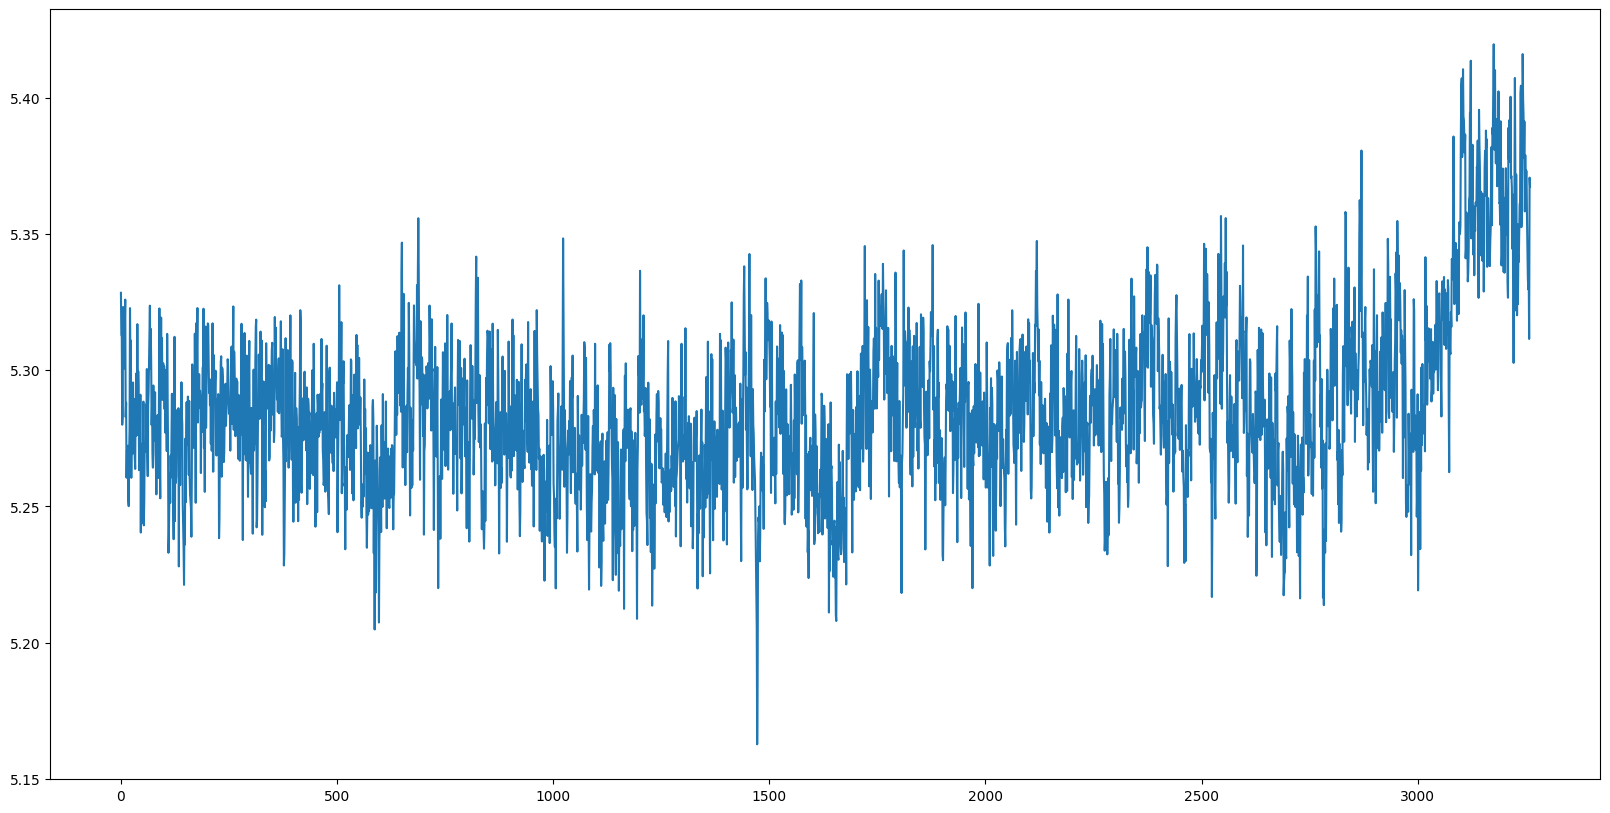

In [40]:
wind.BF1.plot()

<AxesSubplot: >

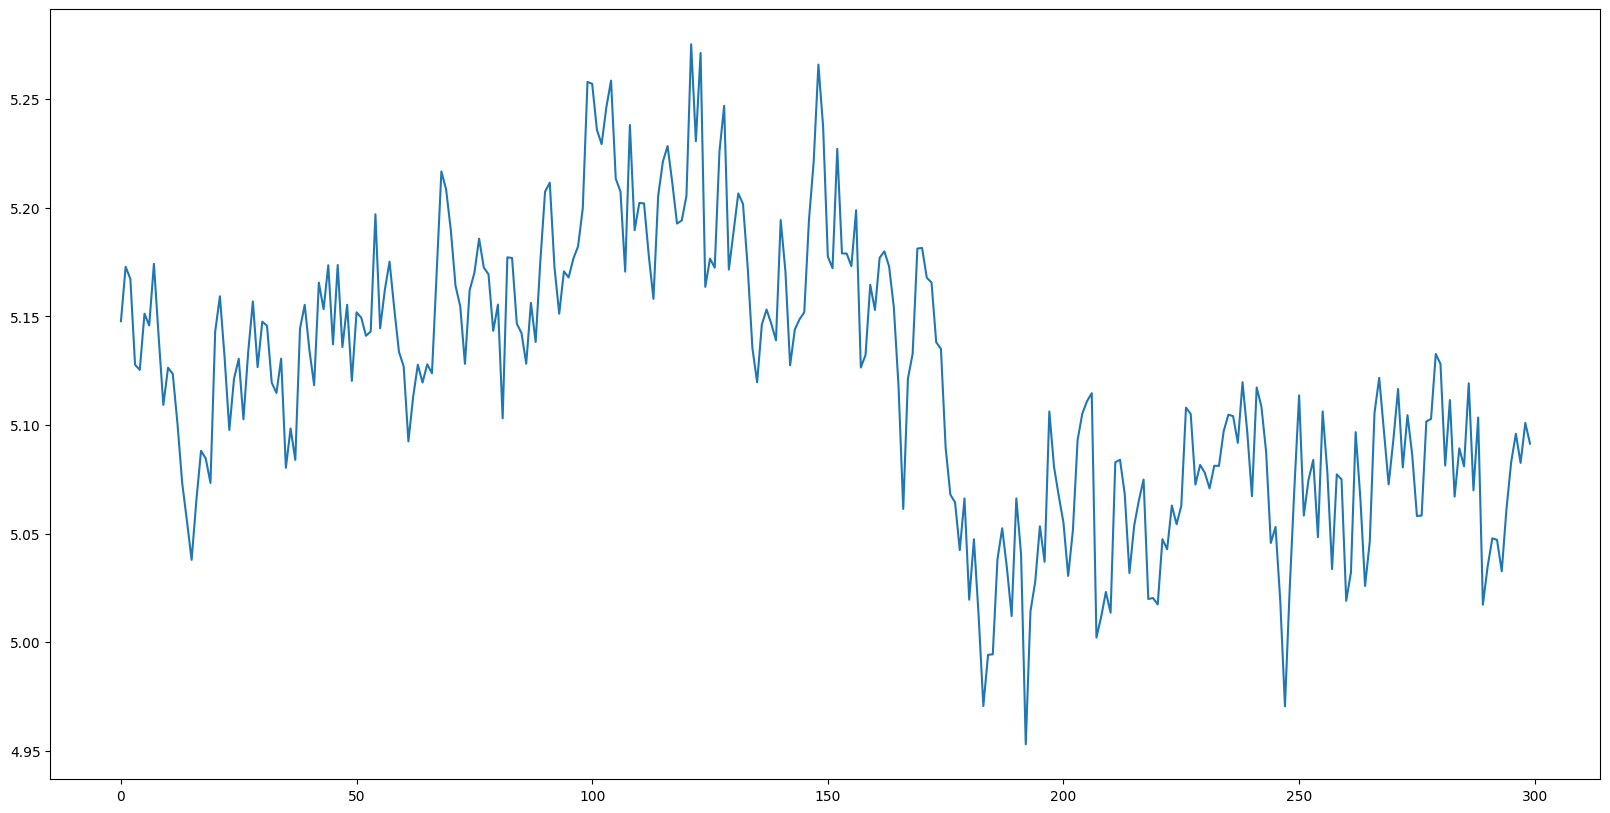

In [44]:
dscovr.B1F1.plot()

# Step 2 - Dynamic Time Warping DSCOVR - WIND Unifying dataset

In [45]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [24]:
distance, path = fastdtw(dscovr['2022-08-25 22:30:00.000':'2022-08-25 23:25:00.000'], wind['2022-08-25 22:15:00.000':'2022-08-25 22:20:00.000'], dist=euclidean)

In [29]:
def union_dtw(x,y,path):
    lista1 = []
    lista2 = []
    n = len(path)
    for j in range(n):
        lista1.append(path[j][0])
    for j in range(n):
        lista2.append(path[j][1])

    lista1 = pd.DataFrame(lista1,columns=['valor'])
    lista1['valor1'] = lista2
    #lista2 = pd.DataFrame(lista2,columns=['valor'])
    #lista1['ind'] = lista1.index
    lista1 = lista1.groupby('valor').agg(minimo=('valor1','min'),maximo=('valor1','max')).reset_index()
    lista1['val'] = ''
    for j in range(lista1.shape[0]):
        lista1['val'][j] = y.reset_index().iloc[lista1.minimo[j]:(lista1.maximo[j]+1)].BF1.mean()
    
    #lista1['time'] = x.index.values
    return lista1


In [30]:
wind2  = union_dtw(dscovr,wind,path)

/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/2412880126.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista1['val'][j] = y.reset_index().iloc[lista1.minimo[j]:(lista1.maximo[j]+1)].BF1.mean()
/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/2412880126.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista1['val'][j] = y.reset_index().iloc[lista1.minimo[j]:(lista1.maximo[j]+1)].BF1.mean()
/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/2412880126.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [31]:
wind2

,valor,minimo,maximo,val
0,0,0,0,5.136906
1,1,1,1,5.135727
2,2,2,2,5.117191
3,3,3,3,5.133088
4,4,4,4,5.122545
...,...,...,...,...
3289,3289,3256,3256,5.191848
3290,3290,3257,3257,5.198156
3291,3291,3258,3258,5.1582
3292,3292,3259,3259,5.162397


<AxesSubplot: >

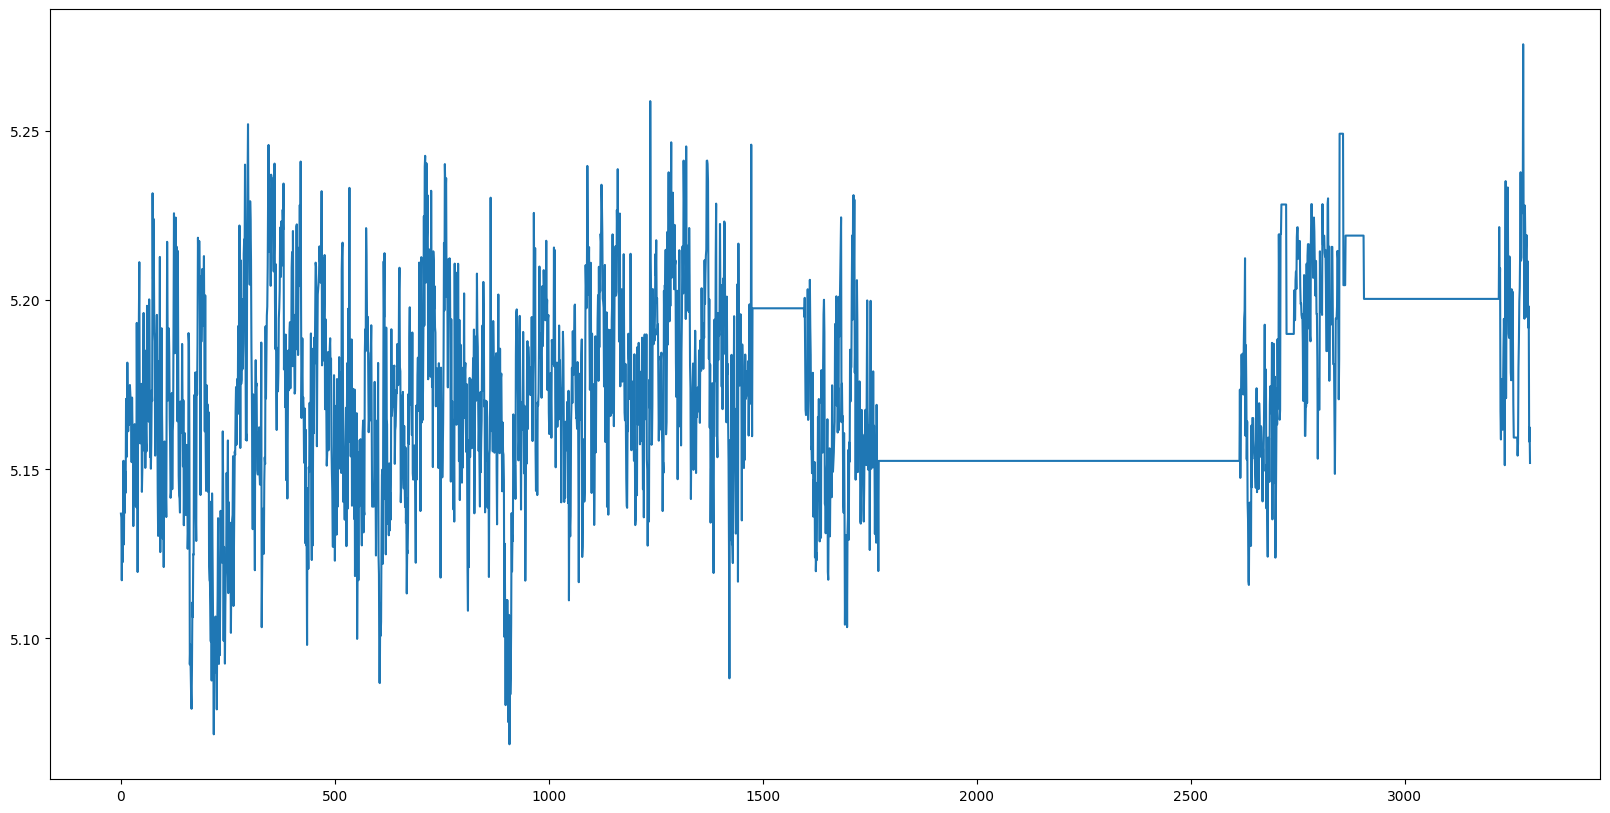

In [32]:
#wind2['time'] = pd.to_datetime(wind2.time)
#wind2.set_index('time', inplace = True)

wind2.val.plot()

In [109]:
#alignment = dtw(dscovr['2022-09-17 22:30:59.000':'2022-09-17 23:25:59.000'], wind['2022-09-17 22:15:59.000':'2022-09-17 22:20:59.000'])#, keep_internals=True)
manhattan_distance = lambda x, y: np.abs(x - y)
d, cost_matrix, acc_cost_matrix, path = dtw(dscovr.B1F1, wind.BF1, dist_method=manhattan_distance)


TypeError: cannot unpack non-iterable DTW object

In [108]:
help(dtw)

Help on function dtw in module dtw.dtw:

dtw(x, y=None, dist_method='euclidean', step_pattern='symmetric2', window_type=None, window_args={}, keep_internals=False, distance_only=False, open_end=False, open_begin=False)
    Compute Dynamic Time Warp and find optimal alignment between two time
    series.
    
    **Details**
    
    The function performs Dynamic Time Warp (DTW) and computes the optimal
    alignment between two time series ``x`` and ``y``, given as numeric
    vectors. The “optimal” alignment minimizes the sum of distances between
    aligned elements. Lengths of ``x`` and ``y`` may differ.
    
    The local distance between elements of ``x`` (query) and ``y``
    (reference) can be computed in one of the following ways:
    
    1. if ``dist_method`` is a string, ``x`` and ``y`` are passed to the
       `scipy.spatial.distance.cdist` function with the method given;
    2. multivariate time series and arbitrary distance metrics can be
       handled by supplying a loc

<AxesSubplot: xlabel='Index', ylabel='Query value'>

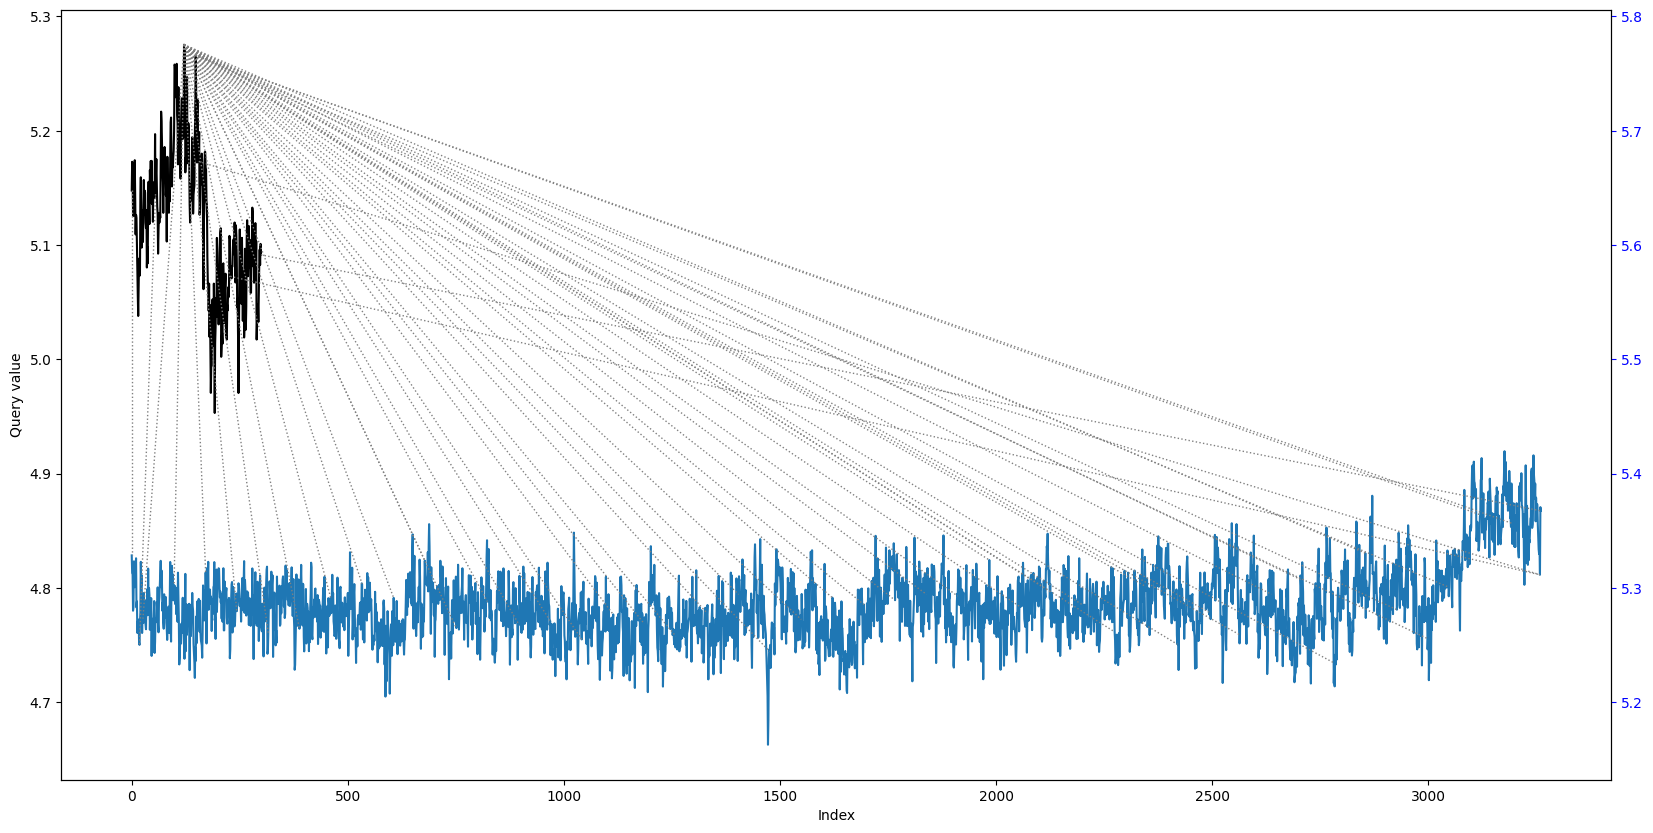

In [49]:
alignment.plot(type="twoway",offset=-0.5)

<AxesSubplot: xlabel='Index', ylabel='Query value'>

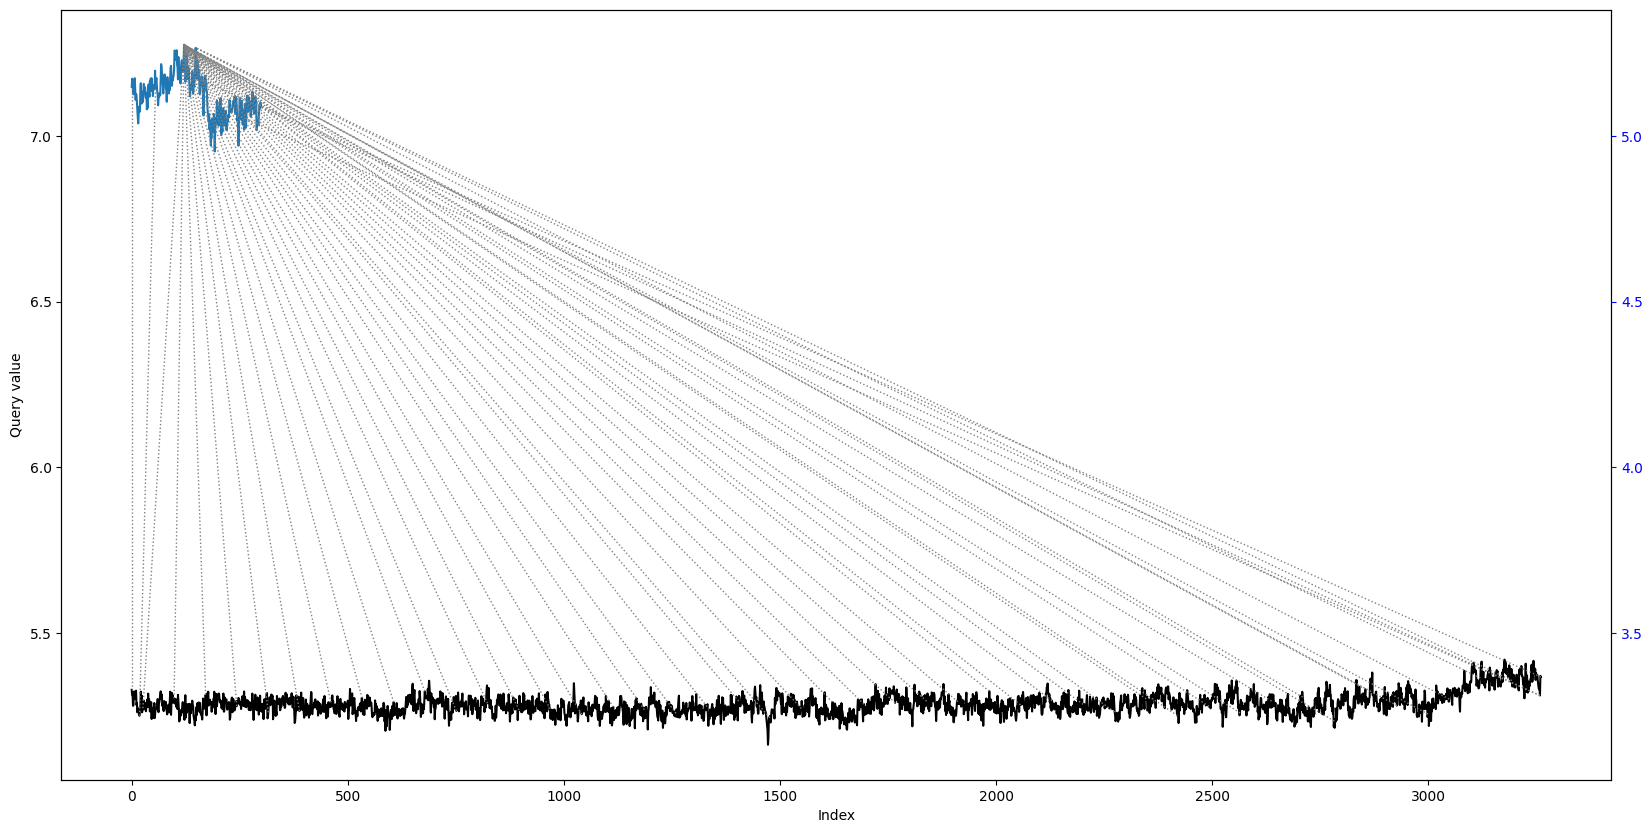

In [111]:
alignment = dtw(wind.BF1, y=dscovr.B1F1, keep_internals=True)
#alignment = dtw(wind.BF1, y=dscovr.B1F1, keep_internals=True)
alignment.plot(type="twoway",offset=2)

In [137]:
dscovr

,B1F1,Epoch1
0,5.147768,2022-08-25 22:15:00.500
1,5.172846,2022-08-25 22:15:01.500
2,5.167292,2022-08-25 22:15:02.500
3,5.127738,2022-08-25 22:15:03.500
4,5.125390,2022-08-25 22:15:04.500
...,...,...
295,5.082879,2022-08-25 22:19:55.500
296,5.095979,2022-08-25 22:19:56.500
297,5.082556,2022-08-25 22:19:57.500
298,5.100989,2022-08-25 22:19:58.500


In [76]:
help(alignment)

Help on DTW in module dtw.dtw object:

class DTW(builtins.object)
 |  DTW(obj)
 |  
 |  The results of an alignment operation.
 |  
 |  Objects of class DTW contain alignments computed by the [dtw()]
 |  function. 
 |  
 |  **Attributes:**
 |  
 |  - ``distance`` the minimum global distance computed, *not* normalized.
 |  - ``normalizedDistance`` distance computed, *normalized* for path
 |    length, if normalization is known for chosen step pattern.
 |  - ``N,M`` query and reference length
 |  - ``call`` the function call that created the object
 |  - ``index1`` matched elements: indices in ``x``
 |  - ``index2`` corresponding mapped indices in ``y``
 |  - ``stepPattern`` the ``stepPattern`` object used for the computation
 |  - ``jmin`` last element of reference matched, if ``open_end=True``
 |  - ``directionMatrix`` if ``keep_internals=True``, the directions of
 |    steps that would be taken at each alignment pair (integers indexing
 |    production rules in the chosen step pattern

In [138]:
base = pd.DataFrame(alignment.index2,columns=['valor'])
base['indice'] = base.index.values
base = base.groupby('valor').agg(minim=('indice','min'),maxi=('indice','max')).reset_index()
base['discover'] = dscovr.B1F1.values
base['tiempo'] = dscovr.Epoch1.values

In [146]:
base2 = pd.DataFrame(alignment.index1,columns=['valor'])
base2['indice'] = base2.index.values
base2 = base2.groupby('valor').agg(minim=('indice','min'),maxi=('indice','max')).reset_index()
base2['wind'] = wind.BF1.values
base2['tiempo'] = wind.Epoch.values

<AxesSubplot: >

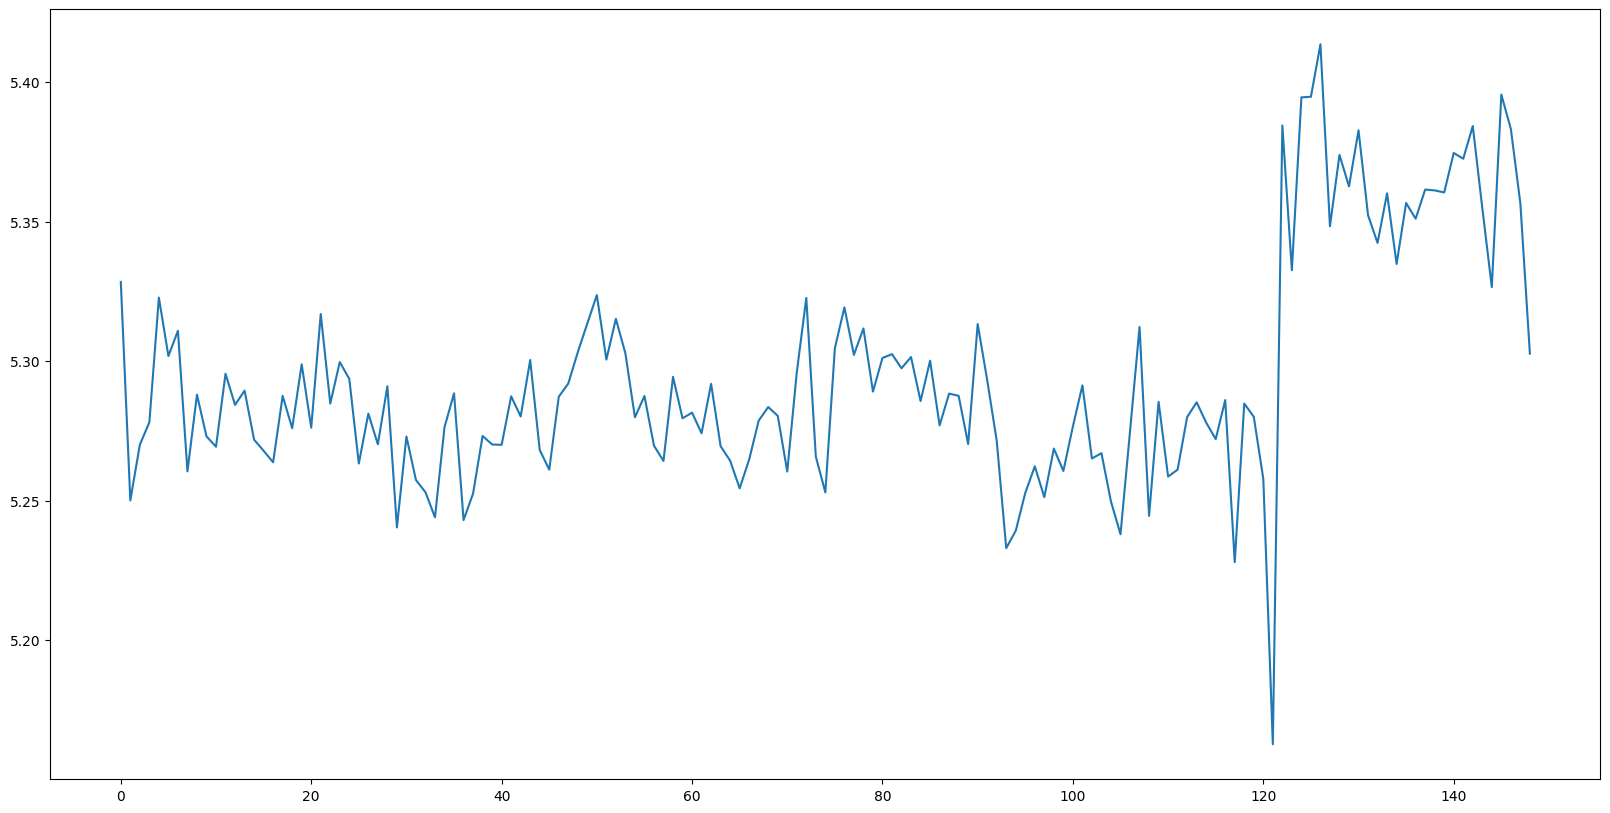

In [156]:
base.val.plot()

<AxesSubplot: >

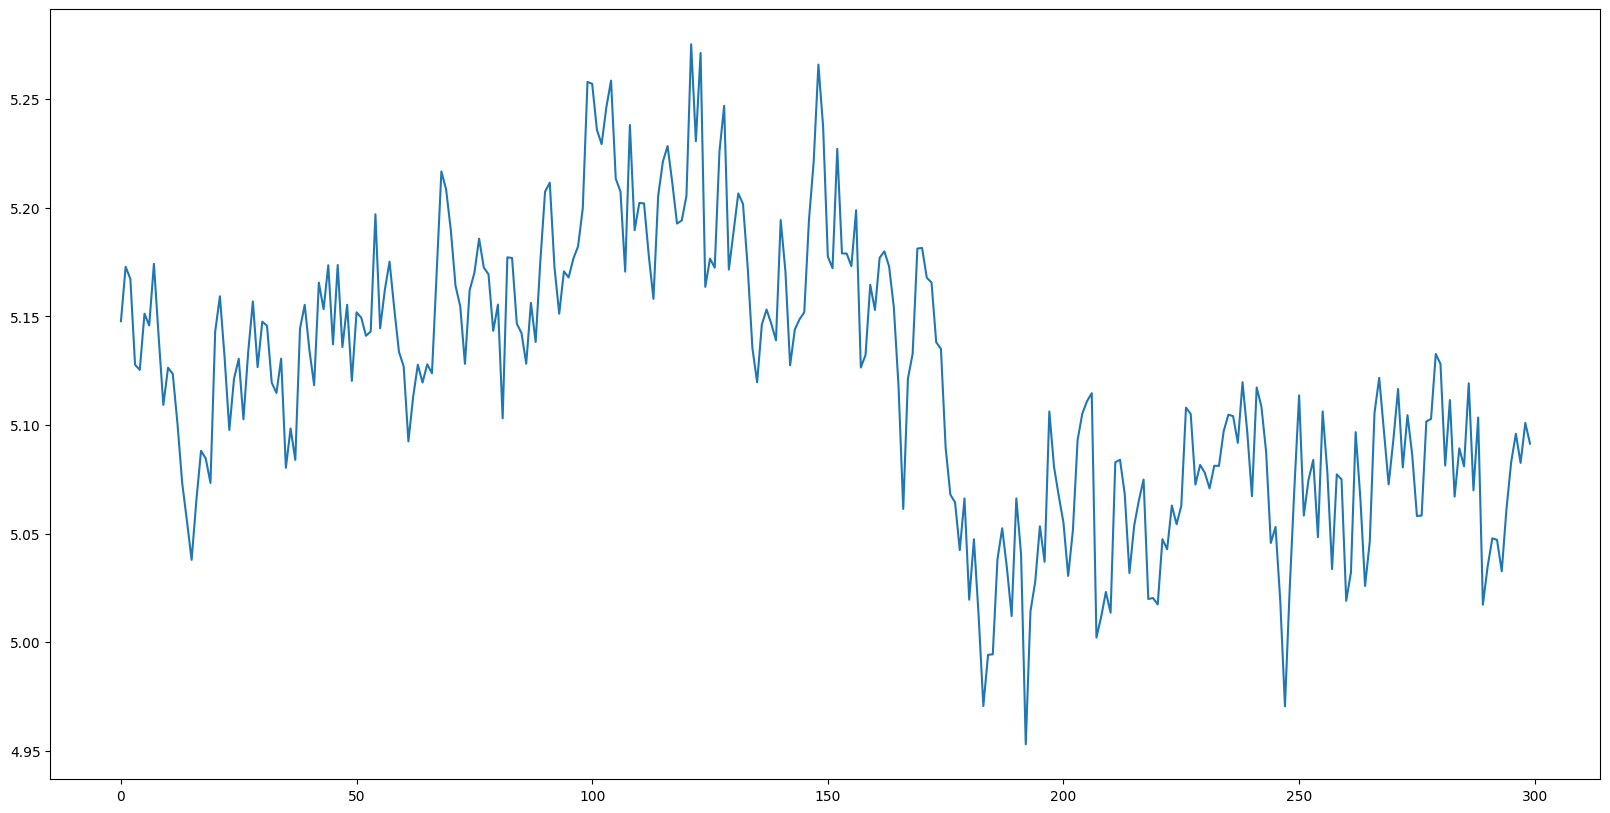

In [157]:
dscovr.B1F1.plot()

In [147]:
base2

,valor,minim,maxi,wind,tiempo
0,0,0,0,5.328383,2022-08-25 22:15:00.064
1,1,1,1,5.312808,2022-08-25 22:15:00.156
2,2,2,2,5.312418,2022-08-25 22:15:00.248
3,3,3,3,5.279988,2022-08-25 22:15:00.340
4,4,4,4,5.283173,2022-08-25 22:15:00.432
...,...,...,...,...,...
3256,3256,3399,3399,5.329632,2022-08-25 22:19:59.616
3257,3257,3400,3400,5.334228,2022-08-25 22:19:59.708
3258,3258,3401,3552,5.311453,2022-08-25 22:19:59.800
3259,3259,3553,3553,5.370634,2022-08-25 22:19:59.892


In [153]:
base['val'] = ''
for j in range(base.shape[0]):
    base['val'][j] = base2.reset_index().iloc[base.minim[j]:(base.maxi[j]+1)].wind.min()

/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/1898899319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['val'][j] = base2.reset_index().iloc[base.minim[j]:(base.maxi[j]+1)].wind.min()
/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/1898899319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['val'][j] = base2.reset_index().iloc[base.minim[j]:(base.maxi[j]+1)].wind.min()
/var/folders/rw/r_3h0nk11gd6qxsmn05m_63m0000gn/T/ipykernel_9196/1898899319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [75]:
import matplotlib.pyplot as plt; 
plt.plot(dscovr[warp(alignment,index_reference=True)])

KeyError: "None of [Int64Index([   0,    9,   18,   18,   18,   18,   18,   18,   18,   18,\n            ...\n            3258, 3258, 3258, 3258, 3258, 3258, 3258, 3258, 3258, 3258],\n           dtype='int64', length=299)] are in the [columns]"

# Step 3 - Selecting Wind Ion Parameters for Unified Dataset

# Step 4 - Prepare DSCOVR spectra data

# Step 5 - Train neural network from DSCVOR data